In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import matplotlib
import ipywidgets
from IPython import display

from torchsummary import summary
from random import seed
from random import randint
from scipy.linalg import sqrtm

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [2]:
# If True, the training will use a buffer of 50 images
train_using_buffer = False
num_epochs = 30
size = 256 # 256 or 128
print('Use buffer: ', train_using_buffer, '\nNumber of epochs: ', num_epochs,'\nImage size: ', size)

Use buffer:  False 
Number of epochs:  30 
Image size:  256


In [3]:
class horse2zebra(torch.utils.data.Dataset):
    def __init__(self, horse, train, transform, data_path='horse2zebra'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        data_path = os.path.join(data_path, 'A' if horse else 'B')
        self.image_paths = glob.glob(data_path + '/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        X = self.transform(image)
        return X #, image_path

In [4]:
#image_means = [0.5225563, 0.44116604, 0.358439]
#image_std = [0.2690048, 0.26258895, 0.27288762]
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.ToTensor()])

# Remember to also normalise test set
# No augmentation of test
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6

# HORSE
trainset_horse = horse2zebra(horse=True, train=True, transform=train_transform)
train_loader_horse = DataLoader(trainset_horse, batch_size=batch_size, shuffle=True, num_workers=3)
testset_horse = horse2zebra(horse=True, train=False, transform=test_transform)
test_loader_horse = DataLoader(testset_horse, batch_size=batch_size, shuffle=False, num_workers=3)

# ZEBRA
trainset_zebra = horse2zebra(horse=False, train=True, transform=train_transform)
train_loader_zebra = DataLoader(trainset_zebra, batch_size=batch_size, shuffle=True, num_workers=3)
testset_zebra = horse2zebra(horse=False, train=False, transform=test_transform)
test_loader_zebra = DataLoader(testset_zebra, batch_size=batch_size, shuffle=False, num_workers=3)

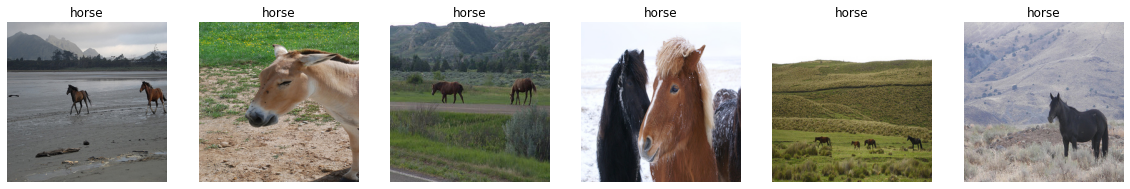

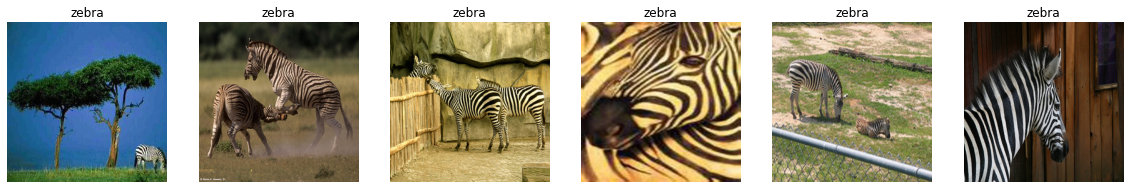

In [5]:
images_h = next(iter(train_loader_horse))
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images_h[i].numpy(), 0, 2), 0, 1))
    plt.title('horse')
    plt.axis('off')

images_z = next(iter(train_loader_zebra))
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images_z[i].numpy(), 0, 2), 0, 1))
    plt.title('zebra')
    plt.axis('off')

In [6]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), 
                                  norm_layer(f), 
                                  nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # three 4x4 convs, stride 2, padding 1, HW reduction
            nn.Conv2d(3,64,4,   stride=2, padding=1), norm_layer(64), nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(64,128,4, stride=2, padding=1), norm_layer(128), nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(128,256,4,stride=2, padding=1), norm_layer(256), nn.LeakyReLU(negative_slope=0.2,inplace=True),
            # Image is now 256x16x16
            
            # Two 4x4 convs, stide 1, padding 1, reduce by 1 pixel
            nn.Conv2d(256,512,4,stride=1, padding=1), norm_layer(512), nn.LeakyReLU(negative_slope=0.2,inplace=True),
            nn.Conv2d(512,1,4,stride=1, padding=1)
            # Output is 1x14x14
        )
    
    def forward(self, x):
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        return x

In [7]:
model = Discriminator().to(device)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
    InstanceNorm2d-2           [-1, 64, 64, 64]               0
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,200
    InstanceNorm2d-5          [-1, 128, 32, 32]               0
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,544
    InstanceNorm2d-8          [-1, 256, 16, 16]               0
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 512, 15, 15]       2,097,664
   InstanceNorm2d-11          [-1, 512, 15, 15]               0
        LeakyReLU-12          [-1, 512, 15, 15]               0
           Conv2d-13            [-1, 1, 14, 14]           8,193
Total params: 2,764,737
Trainable param

In [8]:
# FID, For this, we use a pre-trained version of inception V3 (it takes some time to download)
# https://pytorch.org/hub/pytorch_vision_inception_v3/
model_v3 = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
model_v3.to(device)
model_v3.eval()

# Set parameters to be non-trainable, freeze weights
for param in model_v3.parameters():
  param.requires_grad = False

# Remove the last (fully connected layer)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model_v3.fc = Identity()

Using cache found in /zhome/2e/4/117738/.cache/torch/hub/pytorch_vision_v0.6.0


In [9]:
### Function for computing FID on the test set ###
# Inception V3 expect images to have dimension 299^2 so the images should be resizes
# Also, range should be between 0 and 1, verify lis
def FID(gen_h2z, gen_z2h, h_loader, z_loader):
    z_real, h_fake = [], []
    h_real, z_fake = [], []

    ### Compute real zebras and fake horses ###
    for minibatch_no, zebra in enumerate(z_loader):
        zebra_real = zebra.to(device)

        with torch.no_grad():
            horse_fake = gen_z2h(zebra_real)
            # Rescale
            zebra_real= F.interpolate(zebra_real, size=(299, 299), mode = 'bilinear', align_corners=False)
            horse_fake= F.interpolate(horse_fake, size=(299, 299), mode = 'bilinear', align_corners=False)
            # Run through inception v3, output is batch_size*2048
            out_z_real = model_v3(zebra_real)
            out_h_fake = model_v3(horse_fake)

        # Append outputs
        z_real.append(out_z_real)
        h_fake.append(out_h_fake)

    ### Compute real horses and fake zebras ###
    for minibatch_no, horse in enumerate(h_loader):
        horse_real = horse.to(device)

        with torch.no_grad():
            zebra_fake = gen_h2z(horse_real)
            # Rescale
            horse_real= F.interpolate(zebra_real, size=(299, 299), mode = 'bilinear', align_corners=False)
            zebra_fake= F.interpolate(horse_fake, size=(299, 299), mode = 'bilinear', align_corners=False)
            # Run through inception v3
            out_h_real = model_v3(horse_real)
            out_z_fake = model_v3(zebra_fake)

        # Append outputs
        h_real.append(out_h_real)
        z_fake.append(out_z_fake)

    ### Compute FID for zebras and horses ###
    # Concatenate lists to tensors
    t_z_real = torch.cat(z_real)
    t_h_fake = torch.cat(h_fake)
    t_h_real = torch.cat(h_real)
    t_z_fake = torch.cat(z_fake)

    # Compute mean across training samples, should have dimension 2048
    mu_z_real = torch.mean(t_z_real,0).cpu().numpy()
    mu_h_fake = torch.mean(t_h_fake,0).cpu().numpy()
    mu_h_real = torch.mean(t_h_real,0).cpu().numpy()
    mu_z_fake = torch.mean(t_z_fake,0).cpu().numpy()
    #print('Means shape: ',mu_z_real.shape,mu_h_fake.shape,mu_h_real.shape,mu_z_fake.shape)

    # Convert to numpy arrays
    np_z_real = t_z_real.cpu().numpy()
    np_h_fake = t_h_fake.cpu().numpy()
    np_h_real = t_h_real.cpu().numpy()
    np_z_fake = t_z_fake.cpu().numpy()

    # Compute the covariance matrix, should have dimension 2048^2
    C_z_real = np.cov(np_z_real, rowvar=False)
    C_h_fake = np.cov(np_h_fake, rowvar=False)
    C_h_real = np.cov(np_h_real, rowvar=False)
    C_z_fake = np.cov(np_z_fake, rowvar=False)
    #print('Cov shape: ',C_z_real.shape,C_h_fake.shape,C_h_real.shape,C_z_fake.shape)
    
    #C_mean_h = sqrtm(abs(C_h_real*C_h_fake))
    C_mean_h = sqrtm(C_h_real.dot(C_h_fake))
    if np.iscomplexobj(C_mean_h):
        C_mean_h = C_mean_h.real
    
    #C_mean_z = sqrtm(abs(C_z_real*C_z_fake))
    C_mean_z = sqrtm(C_z_real.dot(C_z_fake))
    if np.iscomplexobj(C_mean_z):
        C_mean_z = C_mean_z.real

    # Compute FID
    FID_h = np.sum((mu_h_real-mu_h_fake)**2) + np.trace(C_h_real + C_h_fake - 2*C_mean_h)
    FID_z = np.sum((mu_z_real-mu_z_fake)**2) + np.trace(C_z_real + C_z_fake - 2*C_mean_z)
    
    #fid_z = calculate_fid(np_z_real, np_z_fake)
    #fid_h = calculate_fid(np_h_real, np_h_fake)
    
    return FID_h, FID_z#, fid_h, fid_z

In [10]:
'''
# example of calculating the frechet inception distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
 
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
 
# define two collections of activations
act1 = random(10*2048)
act1 = act1.reshape((10,2048))
act2 = random(10*2048)
act2 = act2.reshape((10,2048))
# fid between act1 and act1
fid = calculate_fid(act1, act1)
print('FID (same): %.3f' % fid)
# fid between act1 and act2
fid = calculate_fid(act1, act2)
print('FID (different): %.3f' % fid)

FID_horse, FID_zebra, fid_horse, fid_zebra = FID(g_horse2zebra, g_zebra2horse, test_loader_horse, test_loader_zebra)
print('horse and zebra (torch): ', FID_horse, FID_zebra)
print('horse and zebra (lib):', fid_horse, fid_zebra)
'''

"\n# example of calculating the frechet inception distance\nimport numpy\nfrom numpy import cov\nfrom numpy import trace\nfrom numpy import iscomplexobj\nfrom numpy.random import random\n \n# calculate frechet inception distance\ndef calculate_fid(act1, act2):\n    # calculate mean and covariance statistics\n    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)\n    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)\n    # calculate sum squared difference between means\n    ssdiff = numpy.sum((mu1 - mu2)**2.0)\n    # calculate sqrt of product between cov\n    covmean = sqrtm(sigma1.dot(sigma2))\n    # check and correct imaginary numbers from sqrt\n    if iscomplexobj(covmean):\n        covmean = covmean.real\n    # calculate score\n    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)\n    return fid\n \n# define two collections of activations\nact1 = random(10*2048)\nact1 = act1.reshape((10,2048))\nact2 = random(10*2048)\nact2 = act2.reshape((10,2048))\n# fid between 

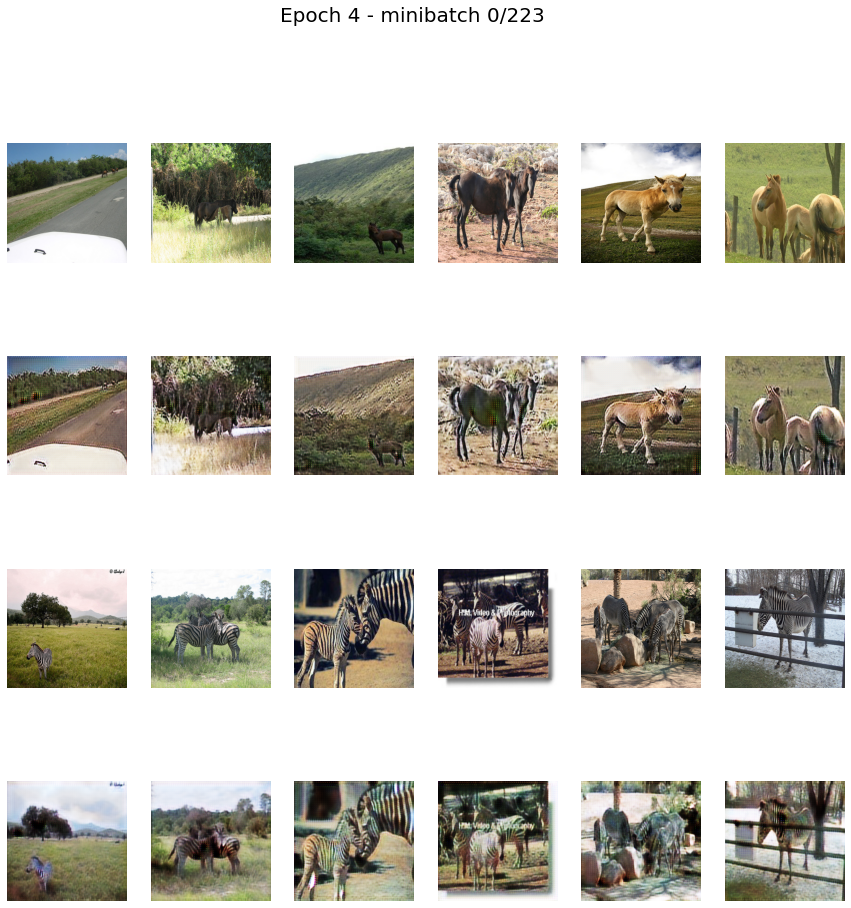

In [ ]:
#Initialize networks
d_horse = Discriminator().to(device)
d_zebra = Discriminator().to(device)
g_horse2zebra = Generator().to(device)
g_zebra2horse = Generator().to(device)

# Get parameters from the models
d_params = list(d_horse.parameters()) + list(d_zebra.parameters())
g_params = list(g_horse2zebra.parameters()) + list(g_zebra2horse.parameters())

# Initialise optimiser
d_opt = torch.optim.Adam(d_params, 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_params, 0.0001, (0.5, 0.999))

discriminator_final_layer = torch.sigmoid

# Weights of the cycle and identity loss
lambda_cycle = 10
lambda_identity = 5
im_criterion = nn.L1Loss()

# LSGAN loss, a = 0, b = 1, c = 1
# a = -1, b = 1, c = 0
def disc_true_loss(x_real, b=1):
  return torch.mean((x_real - b)**2)

def disc_false_loss(x_fake, a=-1):
  return torch.mean((x_fake - a)**2)
  
def gen_loss(x_fake, c=0):
  return torch.mean((x_fake - c)**2)

# Dictionary with losses
loss_dict = {'d_horse': [], 'd_zebra': [], 'ident': [], 'cyc': [], 'g_h2z': [], 
             'g_z2h': [], 'FID_h':[], 'FID_z':[], 'd_h_real_acc': [], 
             'd_h_fake_acc': [], 'd_z_real_acc': [], 'd_z_fake_acc': []}

### Training using buffer of old images
if train_using_buffer == True:
  # Buffer tensor
  buf_horse = torch.rand(50,3,size,size)*2-1
  buf_zebra = torch.rand(50,3,size,size)*2-1
  buf_horse = buf_horse.to(device)
  buf_zebra = buf_zebra.to(device)
  buf_index = 0

  for epoch in range(num_epochs):
    print('Epoch: ', epoch, ' of ', num_epochs)
    # iter() creates a new instance of the data loader for horses
    horse_iter = iter(train_loader_horse)

    # Losses to be stored in dict
    d_horse_lst, d_zebra_lst, ident_lst, cyc_lst, g_h2z_lst, g_z2h_lst = [], [], [], [], [], []
    d_h_real_acc, d_h_fake_acc, d_z_real_acc, d_z_fake_acc = [], [], [], []

    for minibatch_no, zebra in enumerate(train_loader_zebra):
      # Try to fetch the next batch of horses. If it fails that means we have 
      # run through all of the training examples so we create a new iterator
      try:
        horse = next(horse_iter)
      except StopIteration:
        horse_iter = iter(train_loader_horse)
        horse = next(horse_iter)
        horse = next(iter(train_loader_horse))

      zebra_real = zebra.to(device)*2-1 #scale to (-1, 1) range
      horse_real = horse.to(device)*2-1 #scale to (-1, 1) range

      # Setting gradients to zero
      d_opt.zero_grad()
      g_opt.zero_grad()
      d_loss = 0
      g_loss = 0

      ''' Network with real horse input ''' 

      # Calculating discriminator of real horse image
      out_horse_real = d_horse(horse_real)

      # Generating fake zebra image
      zebra_fake = g_horse2zebra(horse_real)

      # Calculating fake zebra image contribution generator loss
      out_zebra_fake = d_zebra(zebra_fake)
      g_h2z_loss_tmp = gen_loss(out_zebra_fake)
      g_loss += g_h2z_loss_tmp

      # Calculating discriminator of fake zebra image
      out_zebra_fake = d_zebra(zebra_fake.detach())
      out_zebra_buff = d_zebra(buf_zebra[[randint(0,49),randint(0,49)]])

      # Discriminator loss related to the real horse image and fake zebra image
      d_horse_loss_tmp = (disc_true_loss(out_horse_real) + disc_false_loss(out_zebra_fake) + disc_false_loss(out_zebra_buff))
      d_loss += d_horse_loss_tmp
      
      # Generating recunstructed horse image
      horse_rec = g_zebra2horse(zebra_fake)

      # Identity of the horse
      horse_id  = g_zebra2horse(horse_real)

      # ImLoss using the L1 loss
      horse_id_loss   = im_criterion(horse_id, horse_real)
      horse_cyc_loss  = im_criterion(horse_rec, horse_real)

      ''' Network with real zebra input '''

      # Calculating distributer of real zebra image
      out_zebra_real = d_zebra(zebra_real)

      # Generating fake horse image
      horse_fake = g_zebra2horse(zebra_real)

      # Calculating fake horse image contribution to the generator loss
      out_horse_fake = d_horse(horse_fake)
      g_z2h_loss_tmp = gen_loss(out_horse_fake)
      g_loss += g_z2h_loss_tmp

      # Calculating discriminator of fake horse image
      out_horse_fake = d_horse(horse_fake.detach())
      out_horse_buff = d_horse(buf_horse[[randint(0,49),randint(0,49)]])

      # Discriminator loss related to the real zebra image and fake horse image
      d_zebra_loss_tmp = (disc_true_loss(out_zebra_real) + disc_false_loss(out_horse_fake) + disc_false_loss(out_horse_buff))
      d_loss += d_zebra_loss_tmp
      
      # Generating recunstructed zebra image
      zebra_rec = g_horse2zebra(horse_fake)

      # Identity of the zebra
      zebra_id  = g_horse2zebra(zebra_real)

      # ImLoss using the L1 loss
      zebra_id_loss   = im_criterion(zebra_id, zebra_real)
      zebra_cyc_loss  = im_criterion(zebra_rec, zebra_real)

      # Add the L1 losses to the generator loss
      g_loss += (lambda_identity*(zebra_id_loss + horse_id_loss))
      g_loss += (lambda_cycle*(zebra_cyc_loss + horse_cyc_loss))

      # Losses for the dictionary
      d_horse_lst.append(d_horse_loss_tmp.item())
      d_zebra_lst.append(d_zebra_loss_tmp.item())
      ident_lst.append((zebra_id_loss + horse_id_loss).item())
      cyc_lst.append((zebra_cyc_loss + horse_cyc_loss).item())
      g_h2z_lst.append(g_h2z_loss_tmp.item())
      g_z2h_lst.append(g_z2h_loss_tmp.item())

      # Calculate the discriminator accuracy
      d_h_fake_numel = 1/out_zebra_fake.numel()
      d_h_real_numel = 1/out_horse_real.numel()
      d_h_fake_acc.append(d_h_fake_numel*(discriminator_final_layer(out_zebra_fake)<0.5).sum().cpu())
      d_h_real_acc.append(d_h_real_numel*(discriminator_final_layer(out_horse_real)>0.5).sum().cpu())
      d_z_fake_numel = 1/out_horse_fake.numel()
      d_z_real_numel = 1/out_zebra_real.numel()
      d_z_fake_acc.append(d_z_fake_numel*(discriminator_final_layer(out_horse_fake)<0.5).sum().cpu())
      d_z_real_acc.append(d_z_real_numel*(discriminator_final_layer(out_zebra_real)>0.5).sum().cpu())

      ''' Update discriminators and generators '''
      d_loss.backward()
      g_loss.backward()

      d_opt.step()
      g_opt.step()

      # Updating buffer tensor
      buf_index = buf_index % 50
      buf_horse[buf_index] = horse_fake[0].detach()
      buf_zebra[buf_index] = zebra_fake[0].detach()
      buf_index += 1
      
      #Plot results every 100 minibatches
      if minibatch_no % 100 == 0:
        real_horses = horse_real.cpu().detach().numpy()/2+.5
        fake_zebras = zebra_fake.cpu().detach().numpy()/2+.5
        real_zebras = zebra_real.cpu().detach().numpy()/2+.5
        fake_horses = horse_fake.cpu().detach().numpy()/2+.5

        display.clear_output(wait=True)
        plt.figure(figsize=(15,15))
        for k in range(batch_size):
          plt.subplot(4,batch_size,k+1)
          plt.imshow(np.swapaxes(np.swapaxes(real_horses[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(fake_zebras[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+2*batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(real_zebras[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+3*batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(fake_horses[k], 0, 2), 0, 1))
          plt.axis('off')
        title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader_zebra))
        plt.suptitle(title, fontsize=20)
        plt.show()

    # Compute FID on the test set
    FID_horse, FID_zebra = FID(g_horse2zebra, g_zebra2horse, test_loader_horse, test_loader_zebra)

    # Update the dictionary at the end of every epoch
    loss_dict['d_horse'].append(np.mean(d_horse_lst))
    loss_dict['d_zebra'].append(np.mean(d_zebra_lst))
    loss_dict['ident'].append(np.mean(ident_lst))
    loss_dict['cyc'].append(np.mean(cyc_lst))
    loss_dict['g_h2z'].append(np.mean(g_h2z_lst))
    loss_dict['g_z2h'].append(np.mean(g_z2h_lst))
    loss_dict['FID_h'].append(FID_horse)
    loss_dict['FID_z'].append(FID_zebra)
    loss_dict['d_h_real_acc'].append(np.mean(d_h_real_acc))
    loss_dict['d_h_fake_acc'].append(np.mean(d_h_fake_acc))
    loss_dict['d_z_real_acc'].append(np.mean(d_z_real_acc))
    loss_dict['d_z_fake_acc'].append(np.mean(d_z_fake_acc))

### Train without buffer
else:
  for epoch in range(num_epochs):
    print('Epoch: ', epoch, ' of ', num_epochs)
    # iter() creates a new instance of the data loader for horses
    horse_iter = iter(train_loader_horse)

    # Losses to be stored in dict
    d_horse_lst, d_zebra_lst, ident_lst, cyc_lst, g_h2z_lst, g_z2h_lst = [], [], [], [], [], []
    d_h_real_acc, d_h_fake_acc, d_z_real_acc, d_z_fake_acc = [], [], [], []

    for minibatch_no, zebra in enumerate(train_loader_zebra):
      # Try to fetch the next batch of horses. If it fails that means we have 
      # run through all of the training examples so we create a new iterator
      try:
        horse = next(horse_iter)
      except StopIteration:
        horse_iter = iter(train_loader_horse)
        horse = next(horse_iter)
        horse = next(iter(train_loader_horse))

      zebra_real = zebra.to(device)*2-1 #scale to (-1, 1) range
      horse_real = horse.to(device)*2-1 #scale to (-1, 1) range

      # Setting gradients to zero
      d_opt.zero_grad()
      g_opt.zero_grad()
      d_loss = 0
      g_loss = 0

      ''' Network with real horse input ''' 

      # Calculating real horse image contribution to the discriminator loss
      out_horse_real = d_horse(horse_real)
      #d_loss += -(nn.LogSigmoid()(out_horse_real)).mean()

      # Generating fake zebra image
      zebra_fake = g_horse2zebra(horse_real)

      # Calculating fake zebra image contribution to the generator loss
      out_zebra_fake = d_zebra(zebra_fake)
      #g_loss += -nn.LogSigmoid()(out_zebra_fake).mean()
      g_h2z_loss_tmp = gen_loss(out_zebra_fake)
      g_loss += g_h2z_loss_tmp

      # Calculating fake zebra image contribution to the discriminator loss
      out_zebra_fake = d_zebra(zebra_fake.detach())
      #d_loss += -(nn.LogSigmoid()(-out_zebra_fake)).mean()

      # Discriminator loss related to the real horse image
      d_horse_loss_tmp = (disc_true_loss(out_horse_real) + disc_false_loss(out_zebra_fake))
      d_loss += d_horse_loss_tmp

      # Generating reconstructed horse image
      horse_rec = g_zebra2horse(zebra_fake)

      # Identity of the horse
      horse_id  = g_zebra2horse(horse_real)

      # ImLoss using the L1 loss
      horse_id_loss   = im_criterion(horse_id, horse_real)
      horse_cyc_loss  = im_criterion(horse_rec, horse_real)

      ''' Network with real zebra input '''

      # Calculating real zebra image contribution to the discriminator loss
      out_zebra_real = d_zebra(zebra_real)
      #d_loss += -(nn.LogSigmoid()(out_zebra_real)).mean()

      # Generating fake horse image
      horse_fake = g_zebra2horse(zebra_real)

      # Calculating fake horse image contribution to the generator loss
      out_horse_fake = d_horse(horse_fake)
      #g_loss += -nn.LogSigmoid()(out_horse_fake).mean()
      g_z2h_loss_tmp = gen_loss(out_horse_fake)
      g_loss += g_z2h_loss_tmp

      # Calculating fake horse image contribution to the discriminator loss
      out_horse_fake = d_horse(horse_fake.detach())
      #d_loss += -(nn.LogSigmoid()(-out_horse_fake)).mean()

      # Discriminator loss related to the real zebra image
      d_zebra_loss_tmp = (disc_true_loss(out_zebra_real) + disc_false_loss(out_horse_fake))
      d_loss += d_zebra_loss_tmp

      # Generating reconstructed zebra image
      zebra_rec = g_horse2zebra(horse_fake)

      # Identity of the zebra
      zebra_id  = g_horse2zebra(zebra_real)

      # ImLoss using the L1 loss
      zebra_id_loss   = im_criterion(zebra_id, zebra_real)
      zebra_cyc_loss  = im_criterion(zebra_rec, zebra_real)

      # Add the L1 losses to the generator loss
      g_loss += (lambda_identity*(zebra_id_loss + horse_id_loss))
      g_loss += (lambda_cycle*(zebra_cyc_loss + horse_cyc_loss))

      # Losses for the dictionary
      d_horse_lst.append(d_horse_loss_tmp.item())
      d_zebra_lst.append(d_zebra_loss_tmp.item())
      ident_lst.append((zebra_id_loss + horse_id_loss).item())
      cyc_lst.append((zebra_cyc_loss + horse_cyc_loss).item())
      g_h2z_lst.append(g_h2z_loss_tmp.item())
      g_z2h_lst.append(g_z2h_loss_tmp.item())

      # Calculate the discriminator accuracy
      d_h_fake_numel = 1/out_zebra_fake.numel()
      d_h_real_numel = 1/out_horse_real.numel()
      d_h_fake_acc.append(d_h_fake_numel*(discriminator_final_layer(out_zebra_fake)<0.5).sum().cpu())
      d_h_real_acc.append(d_h_real_numel*(discriminator_final_layer(out_horse_real)>0.5).sum().cpu())
      d_z_fake_numel = 1/out_horse_fake.numel()
      d_z_real_numel = 1/out_zebra_real.numel()
      d_z_fake_acc.append(d_z_fake_numel*(discriminator_final_layer(out_horse_fake)<0.5).sum().cpu())
      d_z_real_acc.append(d_z_real_numel*(discriminator_final_layer(out_zebra_real)>0.5).sum().cpu())

      ''' Update discriminators and generators '''
      d_loss.backward()
      g_loss.backward()

      d_opt.step()
      g_opt.step()

      #Plot results every 100 minibatches
      if minibatch_no % 100 == 0:
        real_horses = horse_real.cpu().detach().numpy()/2+.5
        fake_zebras = zebra_fake.cpu().detach().numpy()/2+.5
        real_zebras = zebra_real.cpu().detach().numpy()/2+.5
        fake_horses = horse_fake.cpu().detach().numpy()/2+.5

        display.clear_output(wait=True)
        plt.figure(figsize=(15,15))
        for k in range(batch_size):
          plt.subplot(4,batch_size,k+1)
          plt.imshow(np.swapaxes(np.swapaxes(real_horses[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(fake_zebras[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+2*batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(real_zebras[k], 0, 2), 0, 1))
          plt.axis('off')
          plt.subplot(4,batch_size,k+1+3*batch_size)
          plt.imshow(np.swapaxes(np.swapaxes(fake_horses[k], 0, 2), 0, 1))
          plt.axis('off')
        title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader_zebra))
        plt.suptitle(title, fontsize=20)
        plt.show()

    # Compute FID on the test set
    FID_horse, FID_zebra = FID(g_horse2zebra, g_zebra2horse, test_loader_horse, test_loader_zebra)

    # Update the dictionary at the end of every epoch
    loss_dict['d_horse'].append(np.mean(d_horse_lst))
    loss_dict['d_zebra'].append(np.mean(d_zebra_lst))
    loss_dict['ident'].append(np.mean(ident_lst))
    loss_dict['cyc'].append(np.mean(cyc_lst))
    loss_dict['g_h2z'].append(np.mean(g_h2z_lst))
    loss_dict['g_z2h'].append(np.mean(g_z2h_lst))
    loss_dict['FID_h'].append(FID_horse)
    loss_dict['FID_z'].append(FID_zebra)
    loss_dict['d_h_real_acc'].append(np.mean(d_h_real_acc))
    loss_dict['d_h_fake_acc'].append(np.mean(d_h_fake_acc))
    loss_dict['d_z_real_acc'].append(np.mean(d_z_real_acc))
    loss_dict['d_z_fake_acc'].append(np.mean(d_z_fake_acc))

In [ ]:
# Save the current state of the models
#torch.save(d_horse.state_dict(), 'd_h_buff_e30_256.pth')
#torch.save(d_zebra.state_dict(), 'd_z_buff_e30_256.pth')
#torch.save(g_horse2zebra.state_dict(), 'g_h2z_buff_e30_256.pth.pth')
#torch.save(g_zebra2horse.state_dict(), 'g_z2h_buff_e30_256.pth.pth')

# Save the dictionary
#np.save('loss_dict_buff_e30_256.npy', loss_dict)  # Using numpy

In [ ]:
# Plot of the losses
plt.figure()
plt.plot(loss_dict['d_horse'],'r',loss_dict['d_zebra'],'b')
plt.legend(['disc. loss horse', 'disc. loss zebra'])
plt.xlabel('Epoch number'), plt.ylabel('LSGAN discriminator loss')

plt.figure()
plt.plot(loss_dict['ident'],'r', loss_dict['cyc'],'b',
         loss_dict['g_h2z'],'g', loss_dict['g_z2h'],'m')
plt.legend(['Identity','Cyclic','horse2zebra','zebra2horse'])
plt.xlabel('Epoch number'), plt.ylabel('LSGAN generator loss')
# Could argue that lambda could be chosen lower since the generator losses have almost the same magnitude

# Plot FID
plt.figure()
plt.plot(loss_dict['FID_h'],'r',loss_dict['FID_z'],'b')
plt.legend(['Horse', 'Zebra'])
plt.xlabel('Epoch number'), plt.ylabel('FID on test set')

# Plot accuracies
plt.figure()
plt.plot(loss_dict['d_h_real_acc'], 'r', loss_dict['d_h_fake_acc'],'b')
plt.plot(loss_dict['d_z_real_acc'], 'g', loss_dict['d_z_fake_acc'],'m')
plt.legend(['Real horses','Fake horses','Real zebras','Fake zebras'])
plt.xlabel('Epoch number'), plt.ylabel('Accuracy')

In [ ]:
train_loader_horse_unsuf = DataLoader(trainset_horse, batch_size=batch_size, shuffle=False, num_workers=3)
train_loader_zebra_unsuf = DataLoader(trainset_zebra, batch_size=batch_size, shuffle=False, num_workers=3)

i=0
for horse in train_loader_horse_unsuf:
    i+=1
    if i == 1:
        break

i=0
for zebra in train_loader_zebra_unsuf:
    i+=1
    if i == 2:
        break

In [ ]:
### Plot img, transform, recovered and identity ###

zebra_real = zebra.to(device)*2-1 #scale to (-1, 1) range
horse_real = horse.to(device)*2-1 #scale to (-1, 1) range

# Run images through the model
with torch.no_grad():
    # Generating fake zebra image
    zebra_fake = g_horse2zebra(horse_real)
    # Generating reconstructed horse image
    horse_rec = g_zebra2horse(zebra_fake)
    # Identity of the horse
    horse_id  = g_zebra2horse(horse_real)
    
    # Generating fake zebra image
    horse_fake = g_zebra2horse(zebra_real)
    # Generating reconstructed horse image
    zebra_rec = g_horse2zebra(horse_fake)
    # Identity of the horse
    zebra_id  = g_horse2zebra(zebra_real)

# Convert to numpy
real_horses = horse_real.cpu().numpy()/2+.5
fake_zebras = zebra_fake.cpu().numpy()/2+.5
rec_horses  = horse_rec.cpu().numpy()/2+.5
id_horses   = horse_id.cpu().numpy()/2+.5

real_zebras = zebra_real.cpu().detach().numpy()/2+.5
fake_horses = horse_fake.cpu().detach().numpy()/2+.5
rec_zebras  = zebra_rec.cpu().numpy()/2+.5
id_zebras   = zebra_id.cpu().numpy()/2+.5

j=1
k=4

font = {'size'   : 26}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

# Plot
plt.figure(figsize=(15,15))
plt.subplot(2,4,1)
plt.imshow(np.swapaxes(np.swapaxes(real_horses[j], 0, 2), 0, 1))
plt.axis('off'), plt.title('Original')
plt.subplot(2,4,2)
plt.imshow(np.swapaxes(np.swapaxes(fake_zebras[j], 0, 2), 0, 1))
plt.axis('off'), plt.title('Horse to zebra')
plt.subplot(2,4,3)
plt.imshow(np.swapaxes(np.swapaxes(rec_horses[j], 0, 2), 0, 1))
plt.axis('off'), plt.title('Recovered')
plt.subplot(2,4,4)
plt.imshow(np.swapaxes(np.swapaxes(id_horses[j], 0, 2), 0, 1))
plt.axis('off'), plt.title('Identity')
plt.subplot(2,4,5)
plt.imshow(np.swapaxes(np.swapaxes(real_zebras[k], 0, 2), 0, 1))
plt.axis('off'), plt.title('Original')
plt.subplot(2,4,6)
plt.imshow(np.swapaxes(np.swapaxes(fake_horses[k], 0, 2), 0, 1))
plt.axis('off'), plt.title('Zebra to horse')
plt.subplot(2,4,7)
plt.imshow(np.swapaxes(np.swapaxes(rec_zebras[k], 0, 2), 0, 1))
plt.axis('off'), plt.title('Recovered')
plt.subplot(2,4,8)
plt.imshow(np.swapaxes(np.swapaxes(id_zebras[k], 0, 2), 0, 1))
plt.axis('off'), plt.title('Identity')